In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from config import *
from plotting import *
from compressible import compressibleSimulation
from incompressible import incompressibleSimulation
from scenarios import *
from solidBC import *


In [2]:
# s = 1
# a = s **2  / config['targetNeighbors'] * np.pi
# r = np.sqrt(a / np.pi)
# print(r)

In [3]:
def getILConfig(radius = 0.23360679774997896, dt = 0.005, c = .2, device = 'cpu', precision = torch.float64):

    config = {
        'radius': radius,
        'targetNeighbors': 20,
        'restDensity': 1000,
        'dt': dt,
        'kappa':1.5,
        'viscosityConstant':0.1,
        'max_neighbors':256,
#         'device':'cpu',
    #     'device':device,
#         'precision': torch.float32,
        'precision': precision,
        'device':device,
        
        'domain':{
            'periodicX':True,
            'periodicY':True,
            'min': [-5, -5],
            'max': [5,5],
            'buffer': 2
        }
        ,
        'solidBoundary':[
            {
                'vertices': [[-1,-1],[1,-1],[1,1],[-1,1]],
                'inverted': False
            }
        ]
    }
    config['maxValue'] = torch.finfo(config['precision']).max

    config['area'] = np.pi * config['radius']**2
    config['support'] = np.sqrt(config['area'] / np.pi * config['targetNeighbors'])

    config['packing'] = minimize(lambda x: evalPacking(x,config), 0.5, method="nelder-mead").x[0]
    config['spacing'] = -minimize(lambda x: evalSpacing(x,config), 0., method="nelder-mead").x[0]
    
    D = (config['domain']['max'][1] - config['domain']['min'][1])
    spacing = config['spacing']
    packing = config['packing']
    n = int(np.ceil((D / config['support'] - 2 * spacing)/packing))
    h = D / (2 * spacing + n * packing)
    area = h**2 / config['targetNeighbors'] * np.pi
    radius = np.sqrt(area / np.pi)
#     print(D, spacing, packing, n, h, area, radius)
    
    config['radius'] = radius
    config['area'] = area
    config['support'] = h
    
    p = config['packing'] * config['support']
    nx = int(np.ceil((config['domain']['max'][0] - config['domain']['min'][0]) / p))
    ny = int(np.ceil((config['domain']['max'][1] - config['domain']['min'][1]) / p))
#     print('nx', nx)
#     print('prior', config['domain']['max'][0])
    config['domain']['max'][0] = config['domain']['min'][0] + nx * p
    config['domain']['max'][1] = config['domain']['min'][1] + ny * p
#     print('after', config['domain']['max'][0])

    minDomain = config['domain']['min']
    maxDomain = config['domain']['max']
#     print(config['domain']['min'], config['domain']['max'])
    
    config['emitters'] = [
#         {
#         'min': overallDomainMin + spacing * np.array([0,0]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0]+ 1,toMin[1]]),
#         'compression': 1.5
#     },{
#         'min': overallDomainMin + spacing * np.array([0,toMax[1]]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0] + 1,toDomain[1]+ 1]),
#         'compression': 1.5
#     }
#         ,{
#         'min': overallDomainMin + spacing * np.array([0,toMin[1] + 1]),
#         'max': overallDomainMin + spacing * np.array([toMin[0],toMax[1]-1]),
#         'compression': 1.5
#     }    
#     ,{
#         'min': overallDomainMin + spacing * np.array([toMax[0]+1,toMin[1] + 1]),
#         'max': overallDomainMin + spacing * np.array([toDomain[0]+1,toMax[1]-1]),
#         'compression': 1.5
#     }
#         ,
#         {
#         'min': overallDomainMin + spacing * np.array([toMin[0],toMin[1]]),
#         'max': overallDomainMin + spacing * np.array([toMax[0],toMax[1]]),
#         'compression': 3.0
#     }
        {
        'min': minDomain + p / 2,
        'max': maxDomain - p / 2,
        'compression': 1.0
    }
    ]


    for emitter in config['emitters']:
        if 'radius' not in emitter:
            emitter['radius'] = config['radius']
        if 'density' not in emitter:
            emitter['density'] = config['restDensity']
        if 'type' not in emitter:
            emitter['type'] = 'once'
        if 'compression' not in emitter:
            emitter['compression'] = 1.0
        if 'velocity' not in emitter:
            emitter['velocity'] = [0.0,0.0]

    if 'gravity' not in config:
        config['gravity'] = [0,0]


    minCompression = config['maxValue']
    for emitter in config['emitters']:
        minCompression = min(minCompression, emitter['compression'])
    config['minCompression'] = minCompression

    config['domain']['virtualMin'] = config['domain']['min']
    config['domain']['virtualMax'] = config['domain']['max']
    config['domain']['min'] = config['domain']['min'] - config['domain']['buffer'] * config['support']
    config['domain']['max'] = config['domain']['max'] + config['domain']['buffer'] * config['support']
    
    addBoundaryBoundaries(config)
    if 'solidBoundary' in config:
        for boundary in config['solidBoundary']:
            boundary['polygon'] = torch.tensor(boundary['vertices'], device = config['device'], dtype = config['precision'])
        
    return config

In [4]:
def getVelocityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidVelocity'], config, simulationState, nx,ny)
    data = np.linalg.norm(uv,axis=2)
    return data
def getVelocityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidVelocity'].detach().cpu().numpy(), axis = 1)

xyPlotFn = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)
scatterPlotFn = lambda config, state: getVelocityScatter(config, state)


In [5]:
def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
#     data = np.linalg.norm(uv,axis=2)
    return uv

def getDensityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidDensity'].detach().cpu().numpy()


In [6]:
from periodicBC import *
from neighborhood import *
from sph import *

<IPython.core.display.Javascript object>


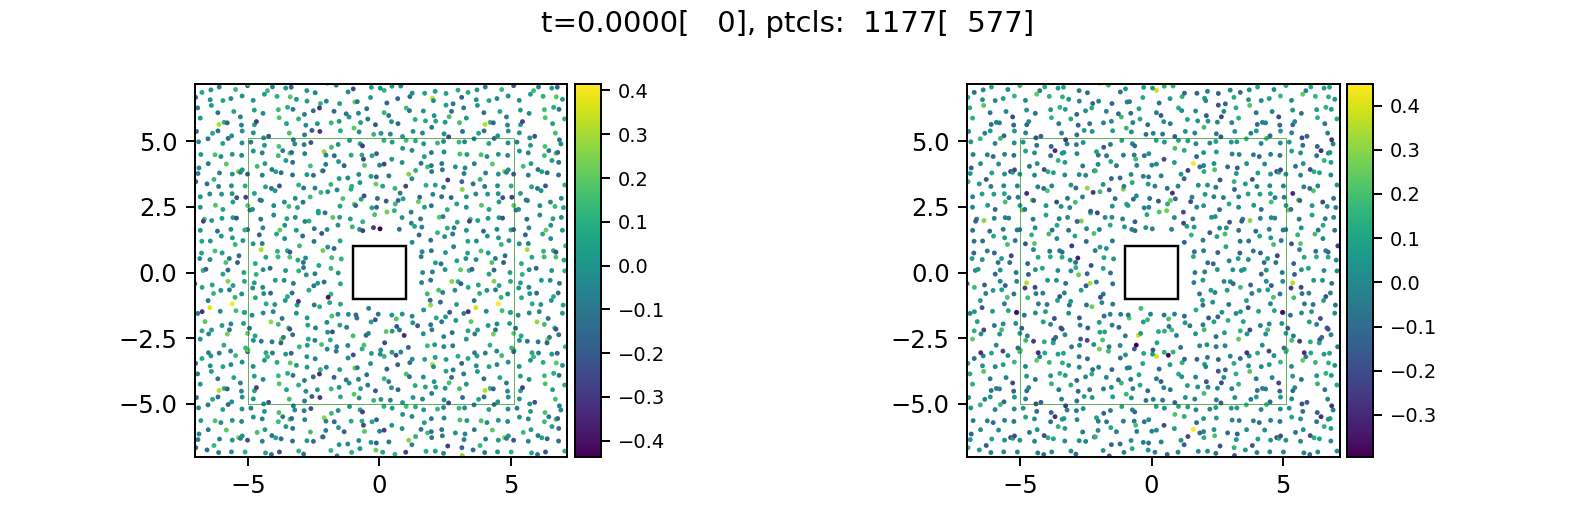

<IPython.core.display.Javascript object>


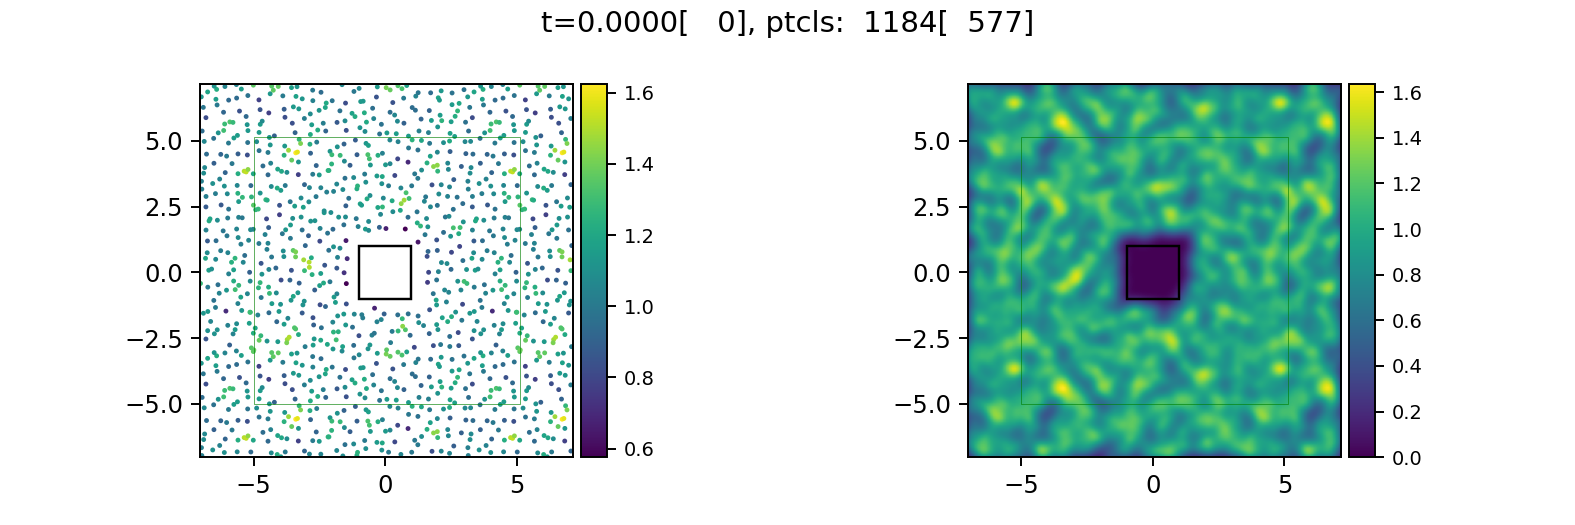

In [7]:
config = getILConfig()
simFn = lambda config, state: compressibleSimulation(config, state)

state = initializeSimulation(config)
enforcePeriodicBC(config, state)

jitter = torch.normal(torch.zeros(state['fluidPosition'].shape, device = config['device'], dtype=config['precision']))\
        * config['support'] / 8
syncQuantity(jitter, config, state)
state['fluidPosition'] += jitter


def getJitterX(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        jitter[:,0].detach().cpu().numpy()
def getJitterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        jitter[:,1].detach().cpu().numpy()


fig, im, axis, cbar = initialPlot(config, state,[getJitterX, getJitterY], 256, 256, figsize=(9,3), plotLayout = (1,2))

enforcePeriodicBC(config, state)

state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
    neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

state['fluidDensity'] = sphDensity(config, state)  

fig, im, axis, cbar = initialPlot(config, state,[getDensityScatter, getDensityXY], 256, 256, figsize=(9,3), plotLayout = (1,2))

In [8]:
from kernel import *
from sph import *

In [9]:
def plotToGrid(data, axis):
    d = torch.clone(data)
    l = int(np.ceil(np.sqrt(data.shape[0])))
    l2 = l**2
#     padShape = d.shape
    padShape = l2 - d.shape[0]
    pad = torch.ones(padShape, device = d.device, dtype=d.dtype)  * torch.nan
    d = torch.cat((d,pad))
    d = d.reshape(l,l,-1)
    im = axis.imshow(d)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
    plt.colorbar(im, cax=cax1)

In [10]:

state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
    state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
    state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)

state['fluidDensity'] = sphDensity(config, state)  

<IPython.core.display.Javascript object>


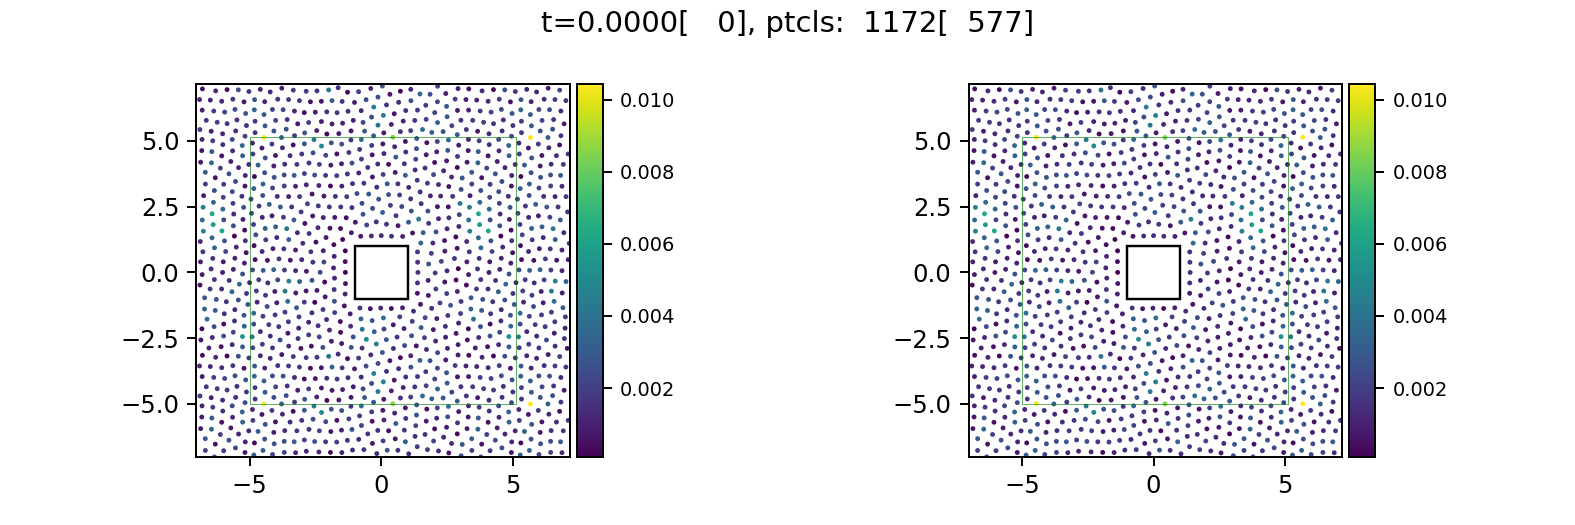

In [11]:
def getUpdateScatterX(config, simulationState):
    return (simulationState['fluidPosition'] - simulationState['fluidUpdate']).detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidUpdate'], axis = 1)
def getUpdateScatterY(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidUpdate'], axis = 1)

solveShifting(config, state)
fig, im, axis, cbar = initialPlot(config, state,[getUpdateScatterX, getUpdateScatterY], 256, 256, figsize=(9,3), plotLayout = (1,2))


In [12]:
for i in tqdm(range(32)):
    solveShifting(config,state)
    state['fluidPosition'] += state['fluidUpdate']

    enforcePeriodicBC(config, state)

    state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
        neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

    state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
        state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
        state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)

    state['fluidDensity'] = sphDensity(config, state)  
    updatePlot(config, state, fig, axis, im, cbar, [getUpdateScatterX, getUpdateScatterY], 256, 256)
    

  0%|          | 0/32 [00:00<?, ?it/s]